# Disclaimer:

DeepSphere.AI developed these
materials based on its team’s expertise
and technical infrastructure, and we
are sharing these materials strictly for
learning and research. These learning
resources may not work on other learning
infrastructures and DeepSphere.AI
advises the learners to use these materials
at their own risk. As needed, we will be
changing these materials without any
notification and we have full ownership
and accountability to make any change
to these materials.

# Import Libraries and Set Configurations

In [1]:
import pandas as pd
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# Class KnowledgeGraph

In [2]:
class KnowledgeGraph:
  def __init__(self, vAR_candidate_sentences):
    #constructor
    #vAR_candidate_sentences - csv input file
    self.vAR_nlp = spacy.load('en_core_web_sm') #load spacy
    self.vAR_candidate_sentences = vAR_candidate_sentences
    self.vAR_entity_pairs = []
    self.vAR_kg_df = None
    self.vAR_relations = None

  def get_entities(self, vAR_sent):
    #method to get entities from input sentence

    #subject, object, dependency, tag of previous token in the sentence, previous token in the sentence
    vAR_ent1 = vAR_ent2 =vAR_prv_tok_dep =vAR_prv_tok_text =vAR_prefix =vAR_modifier = ""

    for tok in self.vAR_nlp(vAR_sent): #tokenize
        
      if (tok.dep_ == "punct"):#if token is punctuation mark then skip it
        continue
      else:
        #compound+compound
        if (tok.dep_ == "compound"):#if token is a compound word
          vAR_prefix = tok.text
          if(vAR_prv_tok_dep == "compound"):#previous word is 'compound'
            vAR_prefix = vAR_prv_tok_text + " "+ tok.text
        
        #compound+modifier
        if(tok.dep_.endswith("mod") == True):#if token is a modifier
          vAR_modifier = tok.text
          if(vAR_prv_tok_dep == "compound"):#previous word is 'compound'
            vAR_modifier = vAR_prv_tok_text + " "+ tok.text
        
        if(tok.dep_.find("subj") == True):#subject
          vAR_ent1 = vAR_modifier +" "+ vAR_prefix + " "+ tok.text
          vAR_prefix =vAR_modifier =vAR_prv_tok_dep =vAR_prv_tok_text = ""      

        if(tok.dep_.find("obj") == True):#object
          vAR_ent2 = vAR_modifier +" "+ vAR_prefix +" "+ tok.text
          
        # update variables previous toke_dep and tok_text
        vAR_prv_tok_dep = tok.dep_
        vAR_prv_tok_text = tok.text

    return [vAR_ent1.strip(), vAR_ent2.strip()]

  def find_entity_pairs(self):
    #method to find entity pairs from sentence
    for i in tqdm(self.vAR_candidate_sentences["sentence"]):
      self.vAR_entity_pairs.append(self.get_entities(i))

  def get_relation(self, vAR_sent):
    #method to get relations
    doc = self.vAR_nlp(vAR_sent)

    # Matcher class object 
    vAR_matcher = Matcher(self.vAR_nlp.vocab)

    #define the pattern 
    #root preposition agent adjective
    vAR_pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':"?"},{'DEP':'agent','OP':"?"},{'POS':'ADJ','OP':"?"}]

    vAR_matcher.add("matching_1", [vAR_pattern], on_match=None)
    matches = vAR_matcher(doc)
    k = len(matches) - 1
    vAR_span = doc[matches[k][1]:matches[k][2]] 
    return(vAR_span.text)

  def find_relations(self):
    #method to display relations
    self.vAR_relations = []
    for i in tqdm(self.vAR_candidate_sentences['sentence']):
        self.vAR_relations.append(self.get_relation(i))

  def extract_subject_and_object(self):
    # extract subject and object from entity pairs
    vAR_source = []
    vAR_target = []
    
    for i in self.vAR_entity_pairs:
        vAR_source.append(i[0])
        vAR_target.append(i[1])

    self.vAR_kg_df = pd.DataFrame({'source':vAR_source, 'target':vAR_target, 'edge':self.vAR_relations})

  def plot_graph(self,var):
    #method to plot graph based on input
    G = nx.from_pandas_edgelist(self.vAR_kg_df[self.vAR_kg_df['edge']==var], "source", "target", edge_attr=True, create_using = nx.MultiDiGraph())
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
    nx.draw(G, with_labels=True, node_size=1500, edge_cmap = plt.cm.Blues, pos = pos)
    plt.show()
    
  def RUN_ALL(self):
    self.find_entity_pairs()
    self.find_relations()
    self.extract_subject_and_object()

# Import Dataset

In [3]:
vAR_candidate_sentences = pd.read_csv("/content/drive/MyDrive/DSAI_KG_Input_Data_Text.csv",encoding='cp1252')
vAR_knowledge_graph_object = KnowledgeGraph(vAR_candidate_sentences)

# Create Object

In [4]:
vAR_knowledge_graph_object = KnowledgeGraph(vAR_candidate_sentences)
vAR_knowledge_graph_object.RUN_ALL()

100%|██████████| 230/230 [00:05<00:00, 43.15it/s]


In [5]:
#display top 10 relations
df = pd.DataFrame(vAR_knowledge_graph_object.vAR_relations, columns=['cols'])
df.value_counts()[:10]

cols   
is         33
Let        10
let         8
are         6
plays       6
use         4
loves       4
teaches     3
gives       3
fixing      3
dtype: int64

Knowledge Graph for Relation : is


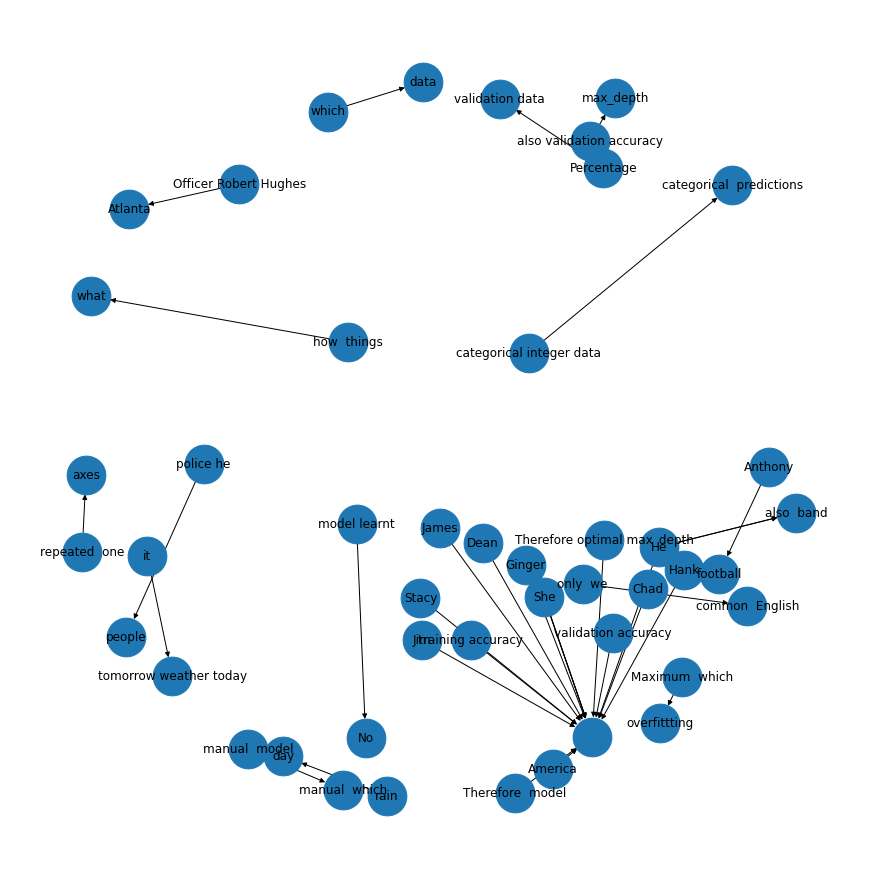

Knowledge Graph for Relation : let


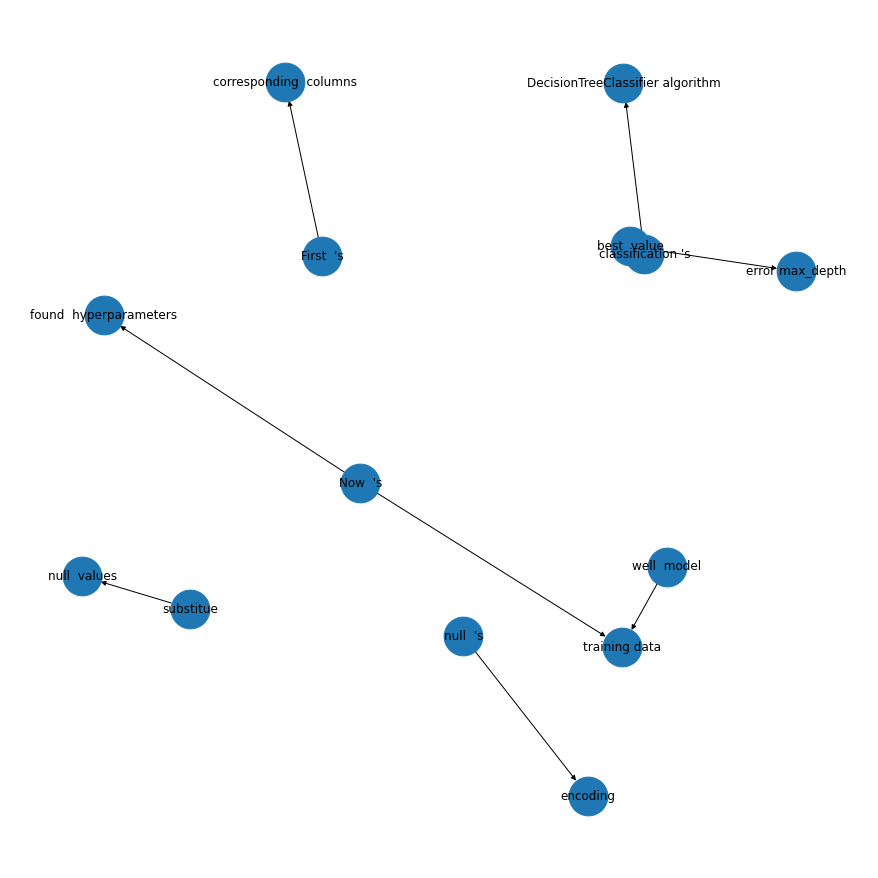

Knowledge Graph for Relation : plays


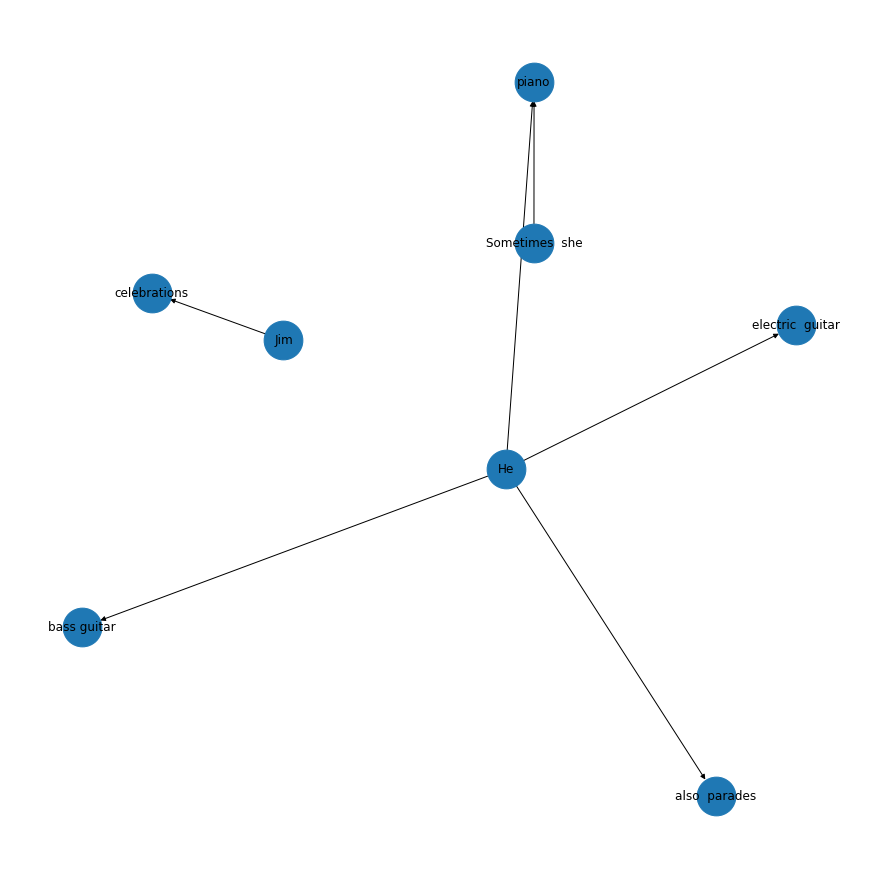

Knowledge Graph for Relation : Let


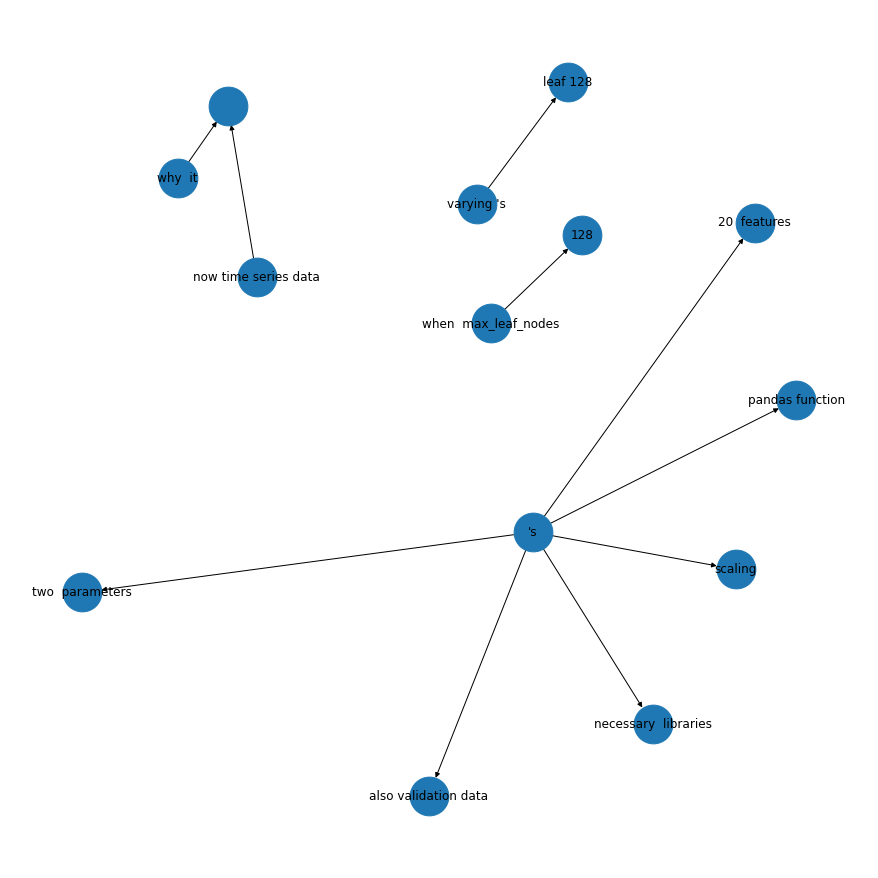

Knowledge Graph for Relation : are


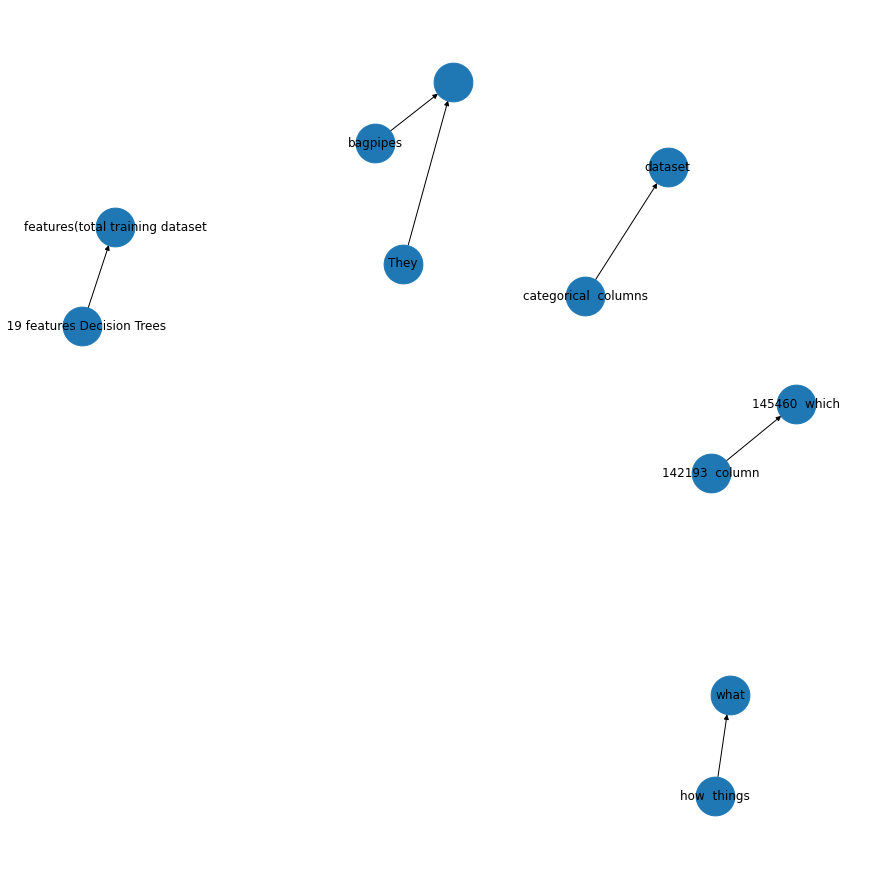

Knowledge Graph for Relation : use


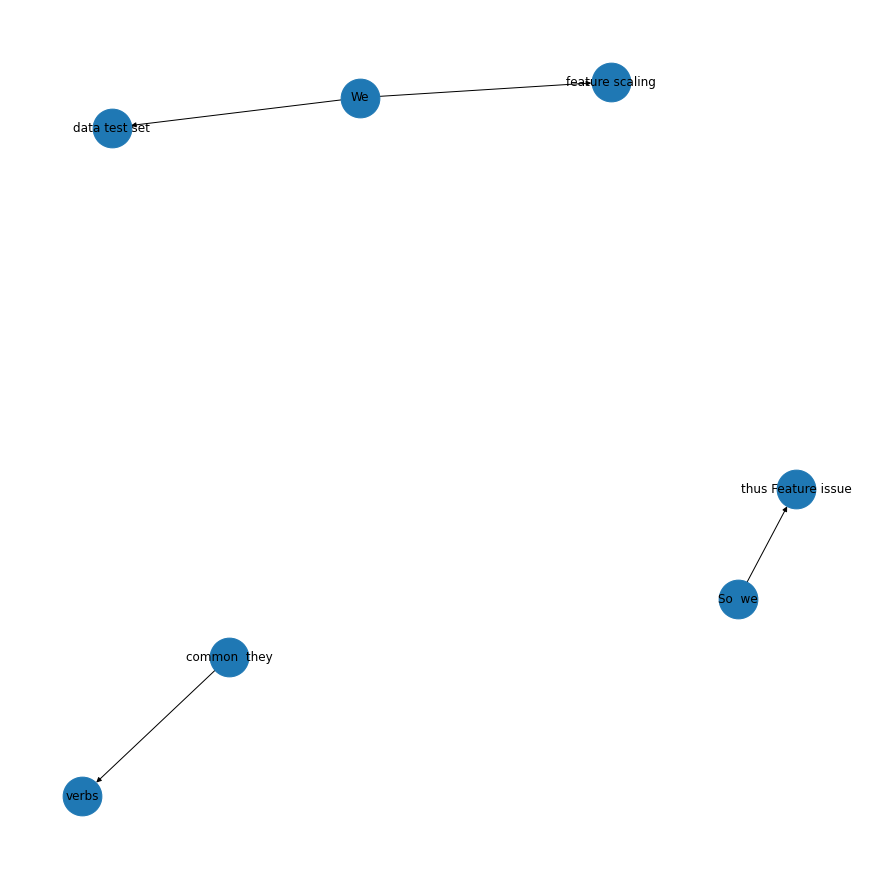

In [6]:
relations = ["is", 'let', 'plays','Let', 'are', 'use']
for i in relations:
    print("Knowledge Graph for Relation :",i)
    vAR_knowledge_graph_object.plot_graph(i)

# Copyright Notice:

Local and international copyright laws protect
this material. Repurposing or reproducing
this material without written approval from
DeepSphere.AI violates the law.

(c) DeepSphere.AI